# Sparkify
This notebook runs on a small sized dataset provided (128 MB), it is meant as an example to be used on larger datsets.

## 1. Import modules and create spark session

In [8]:
# Import modules
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc, col, collect_set
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import mean, count
from pyspark.sql.functions import max as Fmax, concat
from pyspark.sql.types import IntegerType, StringType, TimestampType, LongType 

from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import Evaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

!pip install  ua-parser
from ua_parser import user_agent_parser

In [9]:
# create a Spark session locally on my machine
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", "8g") \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

In [10]:
spark

## 2. Load and Clean Dataset
In this section we load the dataset to a spark dataframe and investigate it.

In [11]:
# Read json file 
event_log = spark.read.json('mini_sparkify_event_data.json')

In [12]:
# Look as the schema
event_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [13]:
# Get the field/features names as a list
fields = event_log.schema.names
print('There are {} features'.format(len(fields)))

There are 18 features


In [14]:
# Get a first look at the data
event_log.select(fields[:9]).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|
|        Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|
|              Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|
|           Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|
|The All-American ...|Logged In|    Micah|     M|           81|    Long|208.29995| free|Boston-Cambridge-...|
|The Velve

In [15]:
event_log.select(fields[10:]).show()

+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|       NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|       NextSong|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|    30|
|       NextSong|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|     9|
|       NextSong|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|    30|
|       NextSong|1538331630000|        8|      Don't Leave Me|   200|1538352678000|"Mozilla/5.0 (Win...|

In [16]:
df = event_log.select(['ts']).describe().toPandas().set_index('summary')

In [17]:
ts_min = int(df.loc['min'].values[0])/1000
ts_max = int(df.loc['max'].values[0])/1000

print('First time stamp is at {}'.format(datetime.utcfromtimestamp(ts_min).strftime('%Y-%m-%d %H:%M:%S')))
print('Last time stamp is at {}'.format(datetime.utcfromtimestamp(ts_max).strftime('%Y-%m-%d %H:%M:%S')))

First time stamp is at 2018-10-01 00:01:57
Last time stamp is at 2018-12-03 01:11:16


In [18]:
print('There are {} events'.format(event_log.count()))

There are 286500 events


### Description of the dataset
The event data has 286500 and 18 features, worth 2 months of data between October and November 2018.
The following features are present:

* __Artist__: Artist of the song being played, if the event does not concert listening to a song the field is null
* __auth (authentication)__: Whether the user Logged in or Logged out, cancelled or guest.
* __firstName__: first name of the user. Null if user has not logged in.
* __gender__: gender of the user (M/F), null if the user has not logged in.
* __itemInSession__: number of events so far in the session. Starts in 0.
* __lastName__: last name of the user. Null if user has not logged in.
* __length__: length of the song (seconds). if the event does not concert listening to a song the field is null.
* __level__: wether the user has a paid subscription of free. (paid/free)
* __location__: location of the user. Seems to be associated to a user.
* __page__: page where the event took place.
* __registration__: registration number associated with each user.
* __sessionId__: number of the session initiated.
* __song__: name of the song being played.
* __status__: http status code (200, 307, 404)
* __ts__: timestamp (ms)
* __userAgent__: information about the device and browser accessing the data.
* __userId__: Id associated with each user.

In [19]:
assert event_log.count() == event_log.dropDuplicates().count(), 'Oops, we have duplicates in our data'

There are no duplicate events

In [20]:
print('{:.1f} % of events have missing userId' \
      .format(event_log.where(event_log.userId == '').count() / event_log.count() * 100))

2.9 % of events have missing userId


I will remove all the rows without userId. It would be possible to impute some of them through the sessionId, but not all of the sessions have only one user. There might be ways to impute the values taking into account userAgents, but since I do not know for sure the relations between features I risk getting null values with larger data sets. For simplicity and robustness I will remove all the rows without a userId.

In [21]:
event_log = event_log.where(event_log.userId != '')

In [22]:
print('After removing empty usersIds we have {} events'.format(event_log.count()))

After removing empty usersIds we have 278154 events


## 3. Exploratory Data Analysis
In this section we will have a closer look at our features and we will understand how the features relate to each other.  We will start by looking at the data and then we will proceed to define __churn__.

### 3.1 Single feature analysis

In [23]:
cat_fields = []
for field in fields:
    n = event_log.select([field]).distinct().count()
    print('{} has {} unique values'.format(field, n))
    if n < 25:
        cat_fields.append(field)

artist has 17656 unique values
auth has 2 unique values
firstName has 189 unique values
gender has 2 unique values
itemInSession has 1311 unique values
lastName has 173 unique values
length has 14866 unique values
level has 2 unique values
location has 114 unique values
method has 2 unique values
page has 19 unique values
registration has 225 unique values
sessionId has 2312 unique values
song has 58481 unique values
status has 3 unique values
ts has 269770 unique values
userAgent has 56 unique values
userId has 225 unique values


In [24]:
event_log.select(['page']).distinct().show(19)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



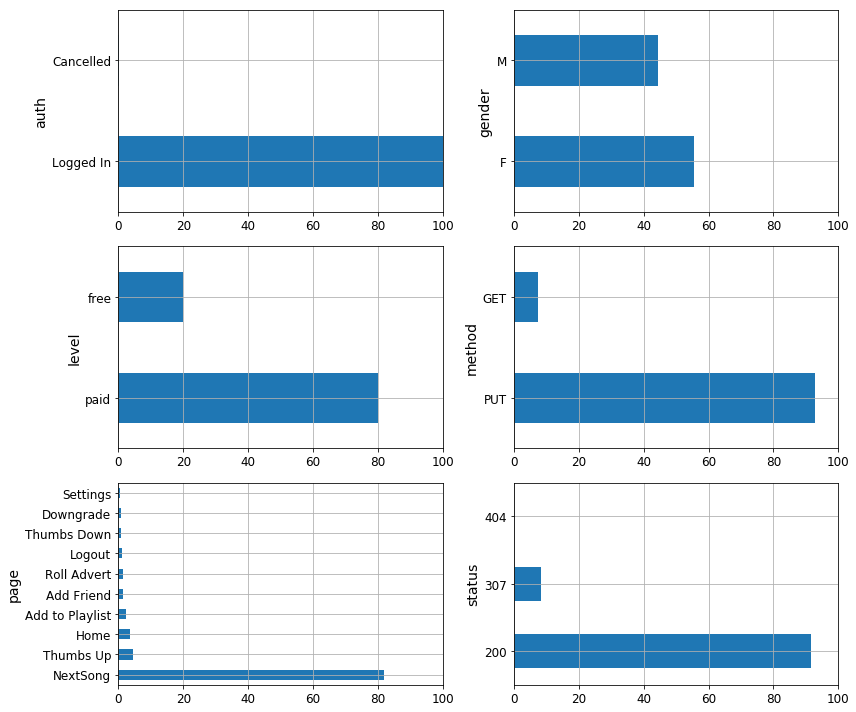

In [25]:
fig, axs = plt.subplots(len(cat_fields)//2,2, figsize=(12,10))
axs = [item for sublist in axs for item in sublist]
N = event_log.count()
for ax, field in zip(axs, cat_fields):
    df = event_log.groupBy(field).count().sort(desc('count')).toPandas()
    df['count'] = df['count'] / N * 100 
    df.set_index(field).iloc[:10].plot.barh(ax=ax, fontsize=12, legend=False, grid=True)
    ax.set_xlim([0, 100])
    ax.yaxis.label.set_fontsize(14)
    
fig.tight_layout()

In [26]:
fig.savefig('pictures/categorical_features_barplot.png')

In [27]:
def spark_hist(x, data, bins=11):
    hist = data.select(x).dropna().rdd.flatMap(lambda x: x).histogram(bins)
    hist_round = zip(list(np.round(hist[0], 1)), hist[1])
    fig, ax = plt.subplots(figsize=(12,6))
    pd.DataFrame(
        hist_round, 
        columns=['bin', 'frequency']
    ).set_index(
        'bin'
    ).plot(kind='bar', width =1, label=x, ax=ax);
    plt.title(x)
    plt.xlabel('seconds')
    plt.xlim([0, bins // 3])
    plt.grid()
    return fig

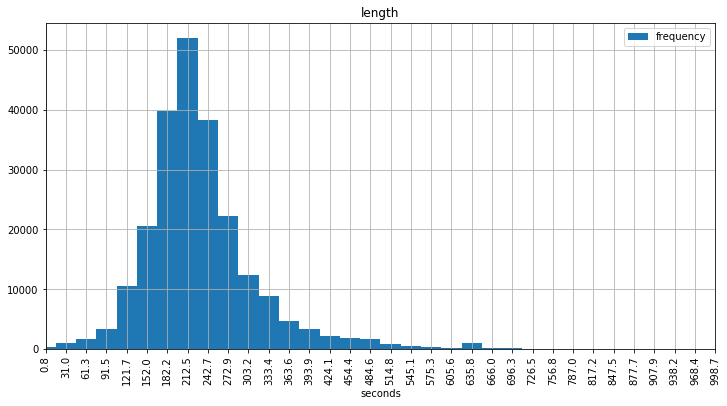

In [28]:
fig = spark_hist(x='length', data=event_log, bins=100)

In [29]:
fig.savefig('pictures/length_hist.png')

In [30]:
event_log.select('length').dropna().describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [31]:
[ q25, q50, q75] = event_log.approxQuantile("length", [ 0.25, 0.5, 0.75], 0.1)
print('Quant. 0.25: {:.1f}s, Quant. 0.5: {:.1f}s, Quant. 0.75: {:.1f}s'\
      .format(q25, q50, q75))

Quant. 0.25: 204.7s, Quant. 0.5: 221.8s, Quant. 0.75: 258.5s


In [33]:
# Top songs and artists
event_log.dropna().groupBy(['song', 'artist']).count().sort(desc('count')).show(5)
event_log.dropna().groupBy(['artist']).count().sort(desc('count')).show(5)

+--------------------+--------------------+-----+
|                song|              artist|count|
+--------------------+--------------------+-----+
|      You're The One|       Dwight Yoakam| 1122|
|                Undo|            BjÃÂ¶rk| 1026|
|             Revelry|       Kings Of Leon|  854|
|       Sehr kosmisch|            Harmonia|  728|
|Horn Concerto No....|Barry Tuckwell/Ac...|  641|
+--------------------+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
+--------------------+-----+
only showing top 5 rows



In [35]:
count_users = udf(lambda l: len(l), IntegerType())
session_user = event_log.select(col('sessionId'), event_log.userId.cast('float').alias('userId')) \
                        .groupBy('sessionId')\
                        .agg(collect_set("userId")) 
session_user  = session_user.withColumn("usersPerSession", count_users(session_user['collect_set(userId)']))
userpersession_df = session_user.groupBy('UsersPerSession').count().toPandas()

In [36]:
userpersession_df['share of sessions [%]'] = userpersession_df['count'] / userpersession_df['count'].sum()*100
userpersession_df.drop('count', axis=1)\
                 .set_index('UsersPerSession')\
                 .style.bar(subset=['share of sessions [%]'], color='#d65f5f')

,share of sessions [%]
UsersPerSession,
1,79.8443
3,10.4671
4,3.3737
2,6.31488


In our medium sized data set, we have 225 users, 17656 artists and 58481 songs. _registration_, _userId_ and the combination of _first_ and _lastName_ have all 225 unique values.

Most of our events are for paying users. There are more events by men than by women. Most of the events are listening 
to songs (NextSong page, PUT method and status 200)

The median length of out songs is 222 seconds, with at least one of them beeing 3024 seconds and one being 0.78 seconds. The length refers to the time that song has been playing not the actual length of the song.

Most of our sessions are one user only, however in some session there are up to 4 users.

I will now try to look at the behaviour of users.

### 3.2 User behaviour
Let us look at the behaviour of some users:

In [37]:
indexer = StringIndexer(inputCol="level", outputCol="paid")
event_log_paid = indexer.fit(event_log).transform(event_log)

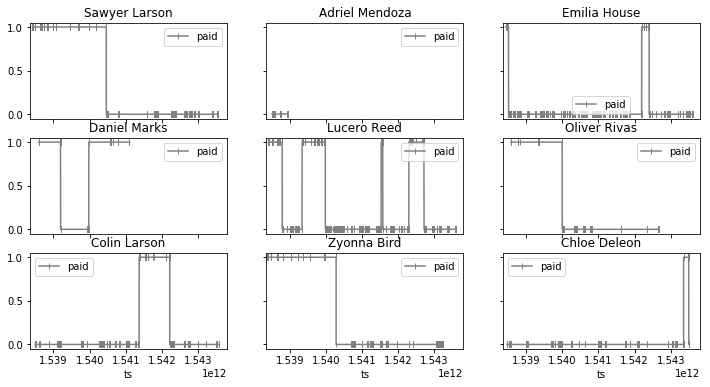

In [38]:
random_users = event_log_paid.select(['userId', 'firstName', 'lastName']).rdd.takeSample(False, 9, seed=0)
fig, axs = plt.subplots(3,3, figsize=(12, 6), sharex=True, sharey=True)
axs = [item for sublist in axs for item in sublist]
for random_user, ax in zip(random_users, axs):
    random_user_id = random_user[0]
    random_user_name = random_user[1] + ' ' + random_user[2]
    random_user_event_log = event_log_paid.filter(event_log.userId == random_user_id)
    df = random_user_event_log.select(['ts', 'paid']).toPandas()
    df.set_index('ts').plot(marker='|', ax=ax, color='gray')
    ax.set_title(random_user_name)
    ax.set_xlim([ts_min*1000, ts_max*1000])

In [39]:
fig.savefig('pictures/user_paying_behavior.png')

As we can see there are many kinds on users:
* some pay and then stop or viceversa
* others switch from paid to unpaid several times.
* Some always pay or never pay

Let's look at the cancellation confirmation and Downgrade page events:

In [40]:
cancelled_confirmed = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
event_log_churn = event_log.withColumn("cancellation", cancelled_confirmed(event_log.page))

In [41]:
event_log_churn.select(['userId', 'cancellation']).groupBy('userId').max().groupby('max(cancellation)').count().show()

+-----------------+-----+
|max(cancellation)|count|
+-----------------+-----+
|                1|   52|
|                0|  173|
+-----------------+-----+



In [42]:
user_cancel = event_log_churn.select(['userId', 'cancellation']).groupBy('userId').max()

In [43]:
users_that_cancelled = user_cancel.filter(user_cancel['max(cancellation)'] == 1).select(['userId'])

In [49]:
print('{} users have cancelled their subscription'.format(users_that_cancelled.count()))

52 users have cancelled their subscription


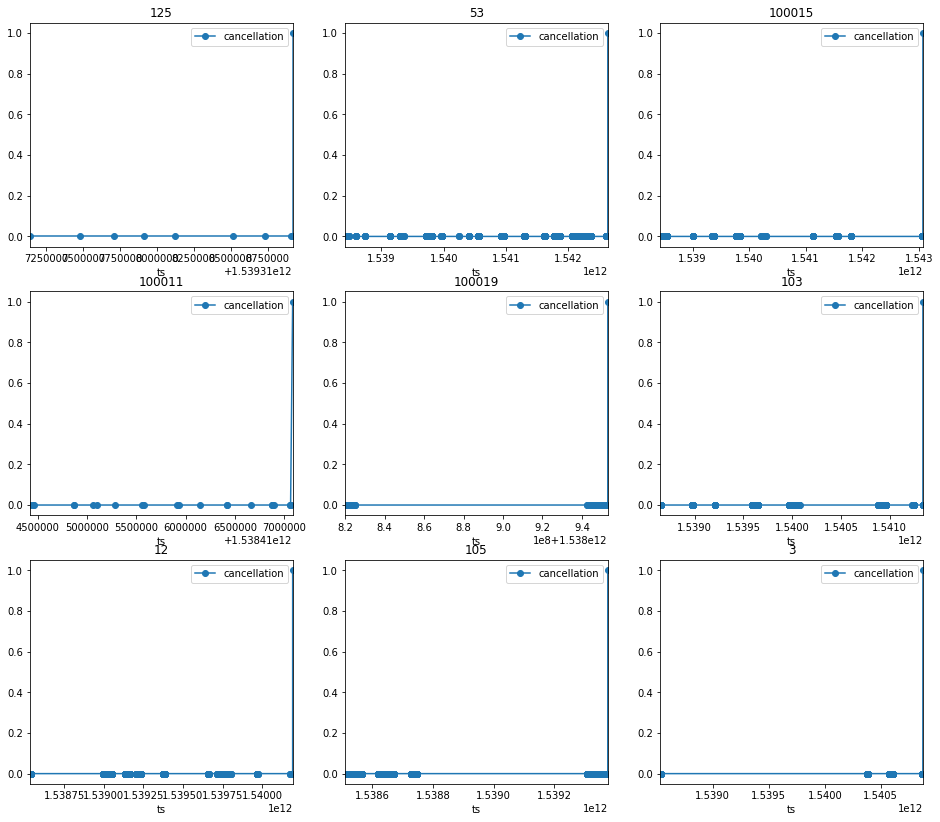

In [45]:
random_users = users_that_cancelled.rdd.takeSample(False, 9, seed=0)
fig, axs = plt.subplots(3,3, figsize=(16,14))
axs = [item for sublist in axs for item in sublist]
for random_user, ax in zip(random_users, axs):
    random_user = random_user[0]
    random_user_event_log = event_log_churn.filter(event_log.userId == random_user)
    df = random_user_event_log.select(['ts', 'cancellation']).toPandas()
    df.set_index('ts').plot(marker='o', ax=ax)
    ax.set_title(random_user)

The people that go through a cancellation confimation page stop using the product under that user name. We have 52 users that cancelled and 173 that haven't cancelled.

In [46]:
registration_submit = udf(lambda x: 1 if x == 'Submit Registration' else 0, IntegerType())
event_log_reg = event_log.withColumn("reg_sub", registration_submit(event_log.page))
event_log_reg.select(['userId', 'reg_sub']).groupBy('userId').max().groupby('max(reg_sub)').count().show()

+------------+-----+
|max(reg_sub)|count|
+------------+-----+
|           0|  225|
+------------+-----+



It seems strange that all users have subit their registration within the time of logged events. I will assume that my data has data from registration for all users.


### 3.3 Define Churn
Churn will be defined as __user goes to the cancellation confirmation page.__ Each row of our dataset will be a user and the label whether that user ever went to the `cancellation confirmation page`.

## 4. Feature Engineering
### 4.1 Event-based features



I will start by extracting new features to every event:
* os (string): Operating system extracted from the userAgent
* browser (string): Browswe used extracted from the userAgent
* paid (integer): 1 or 0 based on the level feature. paid/free
* state (string): state from location
* day (int): day of the week the event took place (0 to 6, monday to sunday)
* hour (int): hour of the day the event took place (0 to 23 hr)
* is_female (int): whether the user is female
* cancellation: whether the event page is cancellation confirmation.

In [50]:
#  Function to use to one-hot encode some category features
def is_value(x):
    """returns a user defined function that returns 1 when equal to x and 0 otherwise"""
    return udf(lambda d: 1 if d == x else 0, IntegerType())

In [51]:
parse_browser = udf(lambda s: user_agent_parser.Parse(s)['user_agent']['family'] if s else None, StringType())
parse_os = udf(lambda s: user_agent_parser.Parse(s)['os']['family'] if s else None, StringType())
get_state = udf(lambda s: s.split(',')[1].strip() if s else None, StringType())
get_day = udf(lambda t: datetime.utcfromtimestamp(int(t)/1000).weekday(), IntegerType())
get_hour = udf(lambda t: datetime.utcfromtimestamp(int(t)/1000).hour, IntegerType())

event_log0 = event_log.withColumn('browser', parse_browser(event_log.userAgent)) \
                           .withColumn('os', parse_os(event_log.userAgent)) \
                           .withColumn('paid', is_value('paid')(event_log.level)) \
                           .withColumn('state', get_state(event_log.location)) \
                           .withColumn('day', get_day(event_log.ts)) \
                           .withColumn('hour', get_hour(event_log.ts)) \
                           .withColumn('is_female', is_value('F')(event_log.gender)) \
                           .withColumn('cancellation', is_value('Cancellation Confirmation')(event_log.page))

There are some states that have more than one state, like `'NY-NJ-PA'`. I will split these and obtain a list of all the unique state names in our data set.

In [52]:
# Impute users with "area" states (several states)
states = [st[0] for st in event_log0.select('state').dropna().distinct().collect()]

clean_states = []
area_states = []
for state in states:
    if '-' in state:
        area_states.append(state)
    else:
        clean_states.append(state)

extracted_states_from_areas = []
for area in area_states:
    extracted_states_from_areas += area.split('-')

for state in extracted_states_from_areas:
    if state not in clean_states:
        clean_states.append(state)
print('There is a total of {} "states"'.format(len(clean_states)))

There is a total of 44 "states"


I will now one-hot encode to new features some categorical features: day, hour, page, state, os, browser.
I will create my own one-hot encoding functions to have more control over the encoding.

In [53]:
def is_in_area(st):
    """returns a user defined function that returns 1 when state is in an area"""
    return udf(lambda a: 1 if (st in a) else 0, IntegerType())

def one_hot_encode_state(df, states):
    """creates new features from the 'state' feature based on the list of states passed as argument"""
    df_new = df
    for state in states: 
        df_new = df_new.withColumn("{}_is_state".format(state), 
                                   is_in_area(state)(df_new['state']))
    return df_new

In [54]:
def one_hot_encode_to_columns(df, cat_feature):
    """Creates new features by one-hot encoding the 'cat_feature'"""
    df_new = df
    features = df.select([cat_feature]).distinct().collect()  # Get all unique categories
    for feature in features:
        feature = feature[0]  # Extract the string from the Row object
        
        if isinstance(feature, str): 
            feature_name = feature.replace(' ', '') # Remove spaces
        else:
            feature_name = feature  
            
        df_new = df_new.withColumn("{}_is_{}".format(cat_feature, feature_name), 
                                   is_value(feature)(df_new[cat_feature]))
    return df_new

In [55]:
is_weekend = udf(lambda d: 1 if d > 4 else 0, IntegerType())
is_afternoon = udf(lambda h: 1 if h > 12 else 0, IntegerType())

In [56]:
# One hot encode state, page, state, os, browser
# Creating 2 new features based on hour and day, wether the event took place on a weekend and if it was after 12:00pm
event_log1 = event_log0
event_log1 = one_hot_encode_to_columns(event_log1, 'page')
event_log1 = one_hot_encode_to_columns(event_log1, 'os')
event_log1 = one_hot_encode_to_columns(event_log1, 'browser')

event_log1 = event_log1.fillna('missing', subset=['state'])
event_log1 = one_hot_encode_state(event_log1, clean_states)

event_log1 = event_log1.withColumn('isWeekend', is_weekend(event_log1.day)) \
                       .withColumn('isAfternoon', is_afternoon(event_log1.hour))

Song and Artist will not be one hot encoded since they have far too many different values. Instead they will be indexed.

In [58]:
# Index song and artist 
indexer_song = StringIndexer(inputCol="song", outputCol="songRank", handleInvalid='keep')
event_log2 = indexer_song.fit(event_log1).transform(event_log1)

indexer_artist = StringIndexer(inputCol="artist", outputCol="artistRank", handleInvalid='keep')
event_log3 = indexer_artist.fit(event_log2).transform(event_log2)

Finally, a new feature, __usersPerSession__ (int): number of users sharing a sessionId.

In [59]:
# session user contains the number of users per session and a list of those users.
count_users = udf(lambda l: len(l), IntegerType())
session_user = event_log0.select(col('sessionId'), event_log.userId.cast('float').alias('userId')) \
                         .groupBy('sessionId')\
                         .agg(collect_set("userId")) 
session_user  = session_user.withColumn("usersPerSession", count_users(session_user['collect_set(userId)']))

event_log4 = event_log3.join(broadcast(session_user), ["sessionId"], how='left') 

### 4.2 User-based features
Now that we have created new features for each event we can start creating aggregated features for each user based on those features.
I will start creating some lists with features to perform specific operations (mean, max, min) and then applying those aggregate functions.

In [60]:
features = event_log4.schema.names  # Retrieve all feature names

page_features = [f for f in features if f.startswith('page_')]  # One-hot encoding from the 'page' feature
page_features.remove('page_is_CancellationConfirmation')  # Remove CancellationConfirmation and Cancel since they
page_features.remove('page_is_Cancel')                    # will be part of the label to predict, not the features.

browser_features = [f for f in features if f.startswith('browser_')]  # One-hot encoding from the 'browser' feature
os_features = [f for f in features if f.startswith('os_')]  # One-hot encoding from the 'os' feature
state_features = [f for f in features if f.endswith('_is_state')]  # One-hot encoding from the 'state' feature

# features to be averaged
avg_features = ['isWeekend', 'isAfternoon', 'songRank', 'is_female', 'artistRank',
                'usersPerSession', 'length', 'paid'] + \
                os_features + browser_features + state_features + page_features
# features to take max from.
max_features = ['page_is_CancellationConfirmation', 'ts']
# features to take min from.
min_features = ['ts']

In [61]:
# Create new dataframes for the aggregate functions
event_log_avg = event_log4.select(avg_features + ['userId']).groupBy('userId').mean()
event_log_max = event_log4.select(max_features + ['userId']).groupBy('userId').max()
event_log_min = event_log4.select(min_features + ['userId']).groupBy('userId').min()
event_log_count = event_log4.groupBy('userId').count()

# Join all the dataframes into a 'user_df'
dfs = [event_log_avg, event_log_max, event_log_min, event_log_count]
user_df = reduce(lambda x, y: x.join(y, ['userId'], how='inner'), dfs)

# Create a new feature called 'totalTime'
user_df = user_df.withColumn('totalTime', col('max(ts)') - col('min(ts)')) \
                 .drop('min(ts)') \
                 .drop('max(ts)')

#user_df = user_df.withColumn('lastWeekStarts', col('max(ts)') - 7*24*3600*1000) \
                 
# Create a new feature called 'events_per_day'
user_df = user_df.withColumn('events_per_day', col('count')/col('totalTime')*24*3600000) 

In [62]:
final_features = user_df.schema.names
n = 4
intervals = zip(range(0, len(final_features), n), range(n, len(final_features), n))
for i, j in intervals:
    user_df.select(final_features[i:j]).show(3)

+------+-------------------+------------------+------------------+
|userId|     avg(isWeekend)|  avg(isAfternoon)|     avg(songRank)|
+------+-------------------+------------------+------------------+
|100010|0.15748031496062992|0.5118110236220472|23727.036745406826|
|200002|                0.0|0.7278481012658228|20213.759493670885|
|   125|                0.0|               0.0|           25421.0|
+------+-------------------+------------------+------------------+
only showing top 3 rows

+--------------+-----------------+--------------------+------------------+
|avg(is_female)|  avg(artistRank)|avg(usersPerSession)|       avg(length)|
+--------------+-----------------+--------------------+------------------+
|           1.0| 6348.48031496063|  3.6325459317585302|  243.421444909091|
|           0.0|4878.126582278481|  3.2510548523206753|242.91699209302305|
|           0.0|6248.909090909091|                 4.0|261.13913750000006|
+--------------+-----------------+--------------------+-

+-----------------------+--------------------+----------------------+-----------------------+
|avg(page_is_ThumbsDown)|   avg(page_is_Home)|avg(page_is_Downgrade)|avg(page_is_RollAdvert)|
+-----------------------+--------------------+----------------------+-----------------------+
|   0.013123359580052493|0.028871391076115485|                   0.0|    0.13648293963254593|
|   0.012658227848101266| 0.04219409282700422|  0.010548523206751054|   0.014767932489451477|
|                    0.0|                 0.0|                   0.0|    0.09090909090909091|
+-----------------------+--------------------+----------------------+-----------------------+
only showing top 3 rows

+--------------------+-------------------------+--------------------+---------------------+
| avg(page_is_Logout)|avg(page_is_SaveSettings)|  avg(page_is_About)|avg(page_is_Settings)|
+--------------------+-------------------------+--------------------+---------------------+
|0.013123359580052493|                   

### 4.3 Save transformed data
As a final step we will save this data. This is a expensive step but it will hugely increase the computation times for modelling and model tuning. The data will have 3 features: the features to model on, the label (churn) and the userId. UserId is necessary to perform a sensible split between train and test data later on.

In [68]:
features = [x for x in final_features if x not in ['max(page_is_CancellationConfirmation)',
                                                   'userId']]

In [69]:
', '.join(features)

'avg(isWeekend), avg(isAfternoon), avg(songRank), avg(is_female), avg(artistRank), avg(usersPerSession), avg(length), avg(paid), avg(os_is_iOS), avg(os_is_Linux), avg(os_is_Ubuntu), avg(os_is_MacOSX), avg(os_is_Windows), avg(browser_is_Firefox), avg(browser_is_Safari), avg(browser_is_MobileSafari), avg(browser_is_IE), avg(browser_is_Chrome), avg(AZ_is_state), avg(SC_is_state), avg(LA_is_state), avg(NJ_is_state), avg(OR_is_state), avg(VA_is_state), avg(KY_is_state), avg(NH_is_state), avg(MI_is_state), avg(NV_is_state), avg(WI_is_state), avg(CA_is_state), avg(CT_is_state), avg(MT_is_state), avg(NC_is_state), avg(MD_is_state), avg(IL_is_state), avg(WA_is_state), avg(MS_is_state), avg(AL_is_state), avg(IN_is_state), avg(OH_is_state), avg(TN_is_state), avg(IA_is_state), avg(PA_is_state), avg(NY_is_state), avg(TX_is_state), avg(WV_is_state), avg(GA_is_state), avg(FL_is_state), avg(CO_is_state), avg(AK_is_state), avg(AR_is_state), avg(OK_is_state), avg(UT_is_state), avg(ID_is_state), avg(RI_i

In [70]:
assembler = VectorAssembler(inputCols=features,
                            outputCol='features', handleInvalid='skip')
df = assembler.transform(user_df)
df = df.select(col('features'),col('max(page_is_CancellationConfirmation)').alias('label'), col('userId'))

In [ ]:
df.write.save('transformed_user_data', format="parquet", header=True)

## 5. Modeing
To perform modelling operations we will use the saved data, since all the DAG has been executed when saving the data to file it will drastically decrease the execution time of these steps.

### 5.1 Load data  and split data

In [63]:
df = spark.read.parquet('transformed_user_data')

In [64]:
df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- userId: string (nullable = true)



In [65]:
df.show(5)
print('{} users/rows'.format(df.count()))

+--------------------+-----+------+
|            features|label|userId|
+--------------------+-----+------+
|(82,[0,1,2,4,5,6,...|    0|   126|
|(82,[0,1,2,4,5,6,...|    0|   131|
|(82,[0,1,2,3,4,5,...|    0|   140|
|(82,[0,1,2,3,4,5,...|    1|    17|
|(82,[0,1,2,3,4,5,...|    0|100004|
+--------------------+-----+------+
only showing top 5 rows

225 users/rows


We will start by splitting our dataset into train (75%) and test set (25%) and chech if the number of churned users is split evenly between train and test set

In [66]:
r_seed = 40
train, test = df.randomSplit([0.7, 0.3], seed=r_seed)

In [67]:
train_1 = train.filter(train.label == 1).count()
train_all = train.count()
test_1 = test.filter(train.label == 1).count()
test_all = test.count()
print('{} churned of {} users, {:.1f} % of users'.format(train_1, train_all, train_1/train_all*100))
print('{} churned of {} users, {:.1f} % of users'.format(test_1, test_all, test_1/test_all*100))

36 churned of 158 users, 22.8 % of users
16 churned of 67 users, 23.9 % of users


### 5.2 Define evaluators

In [72]:
# We will create a function that prints out basic evaluation metrics
def print_confusion_matrix(predictions):
    '''given the results from a model prediction it will print out the confusion matrix, precision, recall,
    accuracy and F1-scaore'''
    tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
    tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
    fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
    fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
    np = predictions[predictions.prediction == 0].count()
    pp = predictions[predictions.prediction == 1].count()
    nl = predictions[predictions.label == 0].count()
    pl = predictions[predictions.label == 1].count()
    t = predictions.count()
    print("Positives in Test set:", pl)
    print("Negatives in Test set:", nl) 
    print("Predicted Positives:", pp) 
    print("Predicted Negatives:", np) 
    print("Total",t ) 

    print("True Positives:", tp)
    print("True Negatives:", tn) 
    print("False Positives:", fp) 
    print("False Negatives:", fn) 
    try:
        p = tp/(tp + fp)
        print("Precision:", p)
        r = tp/(tp + fn)
        print("Recall:", r)
        print("Accuracy:", (tp +tn)/(t))
        print("F1:", 2 * p * r / (p + r))
    except ZeroDivisionError:
        print('Could not calculte due to division by zero')

In [73]:
class myEvaluator(Evaluator):
    """Simple evaluator that takes metricNames: 'recall', 'precision', 'accuracy' and 'f1'."""
    def __init__(self, predictionCol="prediction", labelCol="label", metricName='recall'):
        self.predictionCol = predictionCol
        self.labelCol = labelCol
        self.metricName = metricName
        
    def _evaluate(self, dataset):
        """
        Evaluates the dataset performance, either recall, precision or accuracy
        """
        tp = dataset[(dataset[self.labelCol] == 1) & (dataset[self.predictionCol] == 1)].count()
        tn = dataset[(dataset[self.labelCol] == 0) & (dataset[self.predictionCol] == 0)].count()
        fp = dataset[(dataset[self.labelCol] == 0) & (dataset[self.predictionCol] == 1)].count()
        fn = dataset[(dataset[self.labelCol] == 1) & (dataset[self.predictionCol] == 0)].count()
        t = dataset.count()
        
        if self.metricName == 'recall':
            try:
                return tp/(tp + fn)
            except ZeroDivisionError:
                warnings.warn('Division by 0!')
                return 0
        elif self.metricName == 'precision':
            try:
                return tp/(tp + fp)
            except ZeroDivisionError:
                warnings.warn('Division by 0!')
                return 0
        elif self.metricName == 'accuracy':
            try:
                return (tp +tn)/(t)
            except ZeroDivisionError:
                warnings.warn('Division by 0!')
                return 0
        elif self.metricName == 'f1':
            try:
                p = tp/(tp + fp)
                r = tp/(tp + fn)
                return 2 * p * r / (p + r)
            except ZeroDivisionError:
                warnings.warn('Division by 0!')
                return 0
        else:
            raise ValueError('Unknown metric, the implemented metrics are : recall, precision and accuracy')
            
    def isLargerBetter(self):
        return True

### 5.3 Training and tuning

We will look into 3 of the most common classifiers of pyspark: random forest classifier, logistic regression classifier, and multilayer perceptron classifier.

I will first create a machine learning pipeline containing a scaler and a model. This pipeline will then be tuned using pysparks [`CrossValidator()`](https://spark.apache.org/docs/2.2.0/ml-tuning.html#cross-validation)on the hyperparameters of each model.

#### Logistic Regression

In [74]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

lr = LogisticRegression(featuresCol="scaledFeatures")

pipeline = Pipeline(stages=[scaler, lr])

evaluator = myEvaluator(metricName='f1')

paramGrid = ParamGridBuilder()\
    .addGrid(lr.maxIter, [10, 100, 500]) \
    .addGrid(lr.regParam, [0, 0.4, 0.6, 1])\
    .addGrid(lr.elasticNetParam, [0, 0.5, 1])\
    .addGrid(lr.standardization , [True, False]) \
    .addGrid(lr.aggregationDepth, [2, 3, 4]) \
    .build()

cv_lr = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, seed=r_seed)

In [75]:
model_lr = cv_lr.fit(train)

/anaconda3/envs/sparkify/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Division by 0!


In [76]:
bestModel_lr = model_lr.bestModel

In [77]:
predictions = bestModel_lr.transform(test)
print_confusion_matrix(predictions)

Positives in Test set: 16
Negatives in Test set: 51
Predicted Positives: 22
Predicted Negatives: 45
Total 67
True Positives: 9
True Negatives: 38
False Positives: 13
False Negatives: 7
Precision: 0.4090909090909091
Recall: 0.5625
Accuracy: 0.7014925373134329
F1: 0.47368421052631576


In [78]:
print(bestModel_lr.stages[1]._java_obj.getMaxIter())
print(bestModel_lr.stages[1]._java_obj.getRegParam())
print(bestModel_lr.stages[1]._java_obj.getElasticNetParam())
print(bestModel_lr.stages[1]._java_obj.getStandardization ())
print(bestModel_lr.stages[1]._java_obj.getAggregationDepth ())

10
0.0
0.0
True
2


In [79]:
# Clean the features list for plotting and representation
features = [f.replace('avg(', '') for f in features]
features = [f.replace(')', '') for f in features]
features = [f.replace('browser_is_', '') for f in features]
features = [f.replace('os_is_', '') for f in features]
features = [f.replace('_is_state', '') for f in features]
features = [f.replace('page_is_', '') for f in features]


In [80]:
coefs = pd.DataFrame([features, list(bestModel_lr.stages[1].coefficients)],
                     index=['feature','coef']).T.set_index('feature').sort_values('coef')
idx = list(coefs.index[:5]) + list(coefs.index[-5:])
coefs.loc[idx].style.bar(subset=['coef'], color=['#d65f5f', '#5fba7d'], align='mid')

,coef
feature,
AddFriend,-15.8972
totalTime,-11.8573
MN,-8.67102
ID,-7.88456
UT,-7.88456
Ubuntu,6.43062
ThumbsDown,10.4356
DC,11.6073
AR,11.7064


Text(0, 0.5, '')

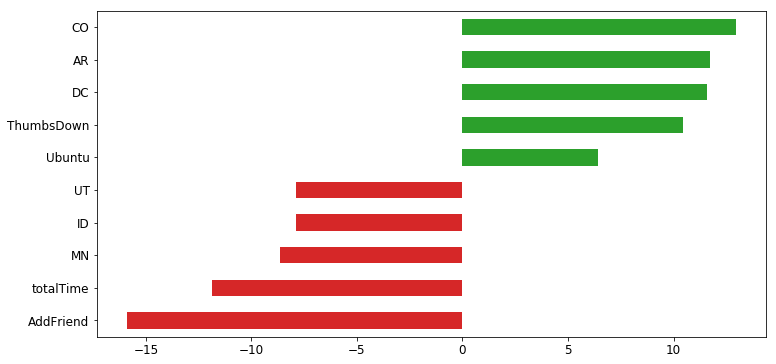

In [81]:
fig, ax = plt.subplots(figsize=(12, 6))
coefs['c'] = coefs.coef > 0
coefs['color'] = coefs.c.map({True: 'tab:green', False: 'tab:red'})
coefs.loc[idx].coef.plot.barh(color=coefs.loc[idx]['color'], fontsize=12, legend=False)
ax.set_ylabel('')

In [82]:
fig.savefig('pictures/lr_feat_imp.png')

Top 5 positive coefficients are : states of CO, AR, DC, the average number of ThumbsDown and the OS Ubuntu

Top 5 negative coefficients are : the average time the added frieds, the total time as customers and the states of MN, ID and UT.

#### Random Forest

In [83]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

rf = RandomForestClassifier(featuresCol="scaledFeatures")

pipeline = Pipeline(stages=[scaler, rf])

evaluator = myEvaluator(metricName='f1')

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [2, 5, 10, 30])\
    .addGrid(rf.minInstancesPerNode, [1, 2, 5]) \
    .build()

cv_rf = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, seed=r_seed)

In [84]:
model_rf = cv_rf.fit(train)

bestModel_rf = model_rf.bestModel

/anaconda3/envs/sparkify/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Division by 0!


In [85]:
predictions = bestModel_rf.transform(test)
print_confusion_matrix(predictions)

Positives in Test set: 16
Negatives in Test set: 51
Predicted Positives: 10
Predicted Negatives: 57
Total 67
True Positives: 7
True Negatives: 48
False Positives: 3
False Negatives: 9
Precision: 0.7
Recall: 0.4375
Accuracy: 0.8208955223880597
F1: 0.5384615384615384


In [86]:
print(bestModel_rf.stages[1]._java_obj.getNumTrees())
print(bestModel_rf.stages[1]._java_obj.getMaxDepth())
print(bestModel_rf.stages[1]._java_obj.getMinInstancesPerNode())


10
5
1


In [87]:
coefs = pd.DataFrame([features, list(bestModel_rf.stages[1].featureImportances)],
                     index=['feature','feat.Imp']).T.set_index('feature').sort_values('feat.Imp')
idx = list(coefs.index[-10:])
coefs.loc[idx].style.bar(subset=['feat.Imp'], color=['#d65f5f', '#5fba7d'], align='mid')

,feat.Imp
feature,
MS,0.0325695
RollAdvert,0.0341734
songRank,0.0435755
Home,0.0449927
NextSong,0.0460496
usersPerSession,0.0534345
AddFriend,0.054838
events_per_day,0.0582384
ThumbsDown,0.0945845


Text(0, 0.5, '')

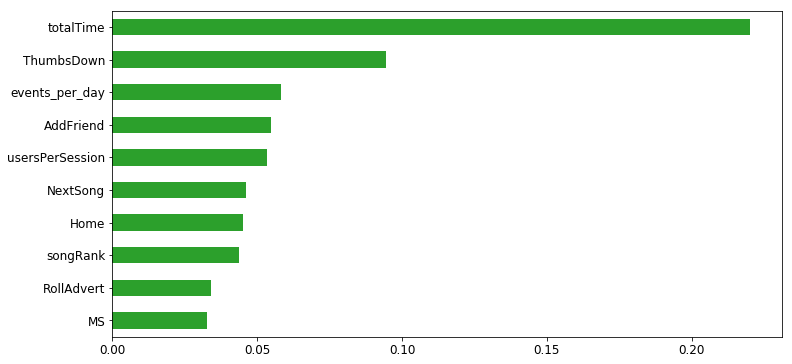

In [88]:
fig, ax = plt.subplots(figsize=(12, 6))
coefs['c'] = coefs['feat.Imp'] > 0
coefs['color'] = coefs.c.map({True: 'tab:green', False: 'tab:red'})
coefs.loc[idx]['feat.Imp'].plot.barh(color=coefs.loc[idx]['color'], fontsize=12, legend=False)
ax.set_ylabel('')

In [89]:
fig.savefig('pictures/rf_feat_imp.png')

The random forest classfier seems to heavily rely on the total time to determine if the user will churn. These are the top 5 features:
1. Total Time
2. events_per_day
3. avg(page_is_ThumbsDown)
4. avg(artistRank)	
5. avg(length)

#### Neural Net

In [91]:
def create_layers(n_layers, input_layer_size, output_layer_size=2):
    layers = [input_layer_size]
    layer_size_reduction = (input_layer_size-output_layer_size)//n_layers
    for i in range(n_layers):
        next_layer = input_layer_size - layer_size_reduction * i
        layers.append(next_layer)
    layers.append(2)
    return layers
    

In [92]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

mlp = MultilayerPerceptronClassifier(featuresCol="scaledFeatures", blockSize=256, seed=r_seed)

pipeline = Pipeline(stages=[scaler, mlp])

evaluator = myEvaluator(metricName='f1')

inputs = df.take(1)[0][0].size
layers = []
for i in range(2, 20):
    layers.append(create_layers(i, inputs))

paramGrid = ParamGridBuilder()\
    .addGrid(mlp.maxIter, [10, 50, 100, 1000]) \
    .addGrid(mlp.layers, layers )\
    .build()

cv_mlp = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, seed=r_seed)

In [93]:
model_mlp = cv_mlp.fit(train)

bestModel_mlp = model_mlp.bestModel

/anaconda3/envs/sparkify/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Division by 0!


In [94]:
predictions = bestModel_mlp.transform(test)
print_confusion_matrix(predictions)

Positives in Test set: 16
Negatives in Test set: 51
Predicted Positives: 21
Predicted Negatives: 46
Total 67
True Positives: 10
True Negatives: 40
False Positives: 11
False Negatives: 6
Precision: 0.47619047619047616
Recall: 0.625
Accuracy: 0.746268656716418
F1: 0.5405405405405405


In [95]:
bestModel_mlp.stages[1].layers

[82, 82, 74, 66, 58, 50, 42, 34, 26, 18, 2]